# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [17]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [18]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [19]:
# Rank the words existing, to figure out the words for stop-word.
from sklearn.feature_extraction.text import CountVectorizer 
movie_data = pd.read_csv('moviereviews_train.tsv', sep='\t')
texts = movie_data['review']
vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
sorted(words_freq, key = lambda x: x[1], reverse=True)

[('the', 336749),
 ('and', 164140),
 ('of', 145864),
 ('to', 135724),
 ('is', 107332),
 ('br', 101871),
 ('it', 96467),
 ('in', 93976),
 ('this', 76007),
 ('that', 73286),
 ('was', 48209),
 ('as', 46935),
 ('for', 44345),
 ('with', 44130),
 ('movie', 44047),
 ('but', 42623),
 ('film', 40159),
 ('you', 34267),
 ('on', 34202),
 ('not', 30632),
 ('he', 30155),
 ('are', 29438),
 ('his', 29376),
 ('have', 27731),
 ('be', 26957),
 ('one', 26795),
 ('all', 23985),
 ('at', 23516),
 ('they', 22915),
 ('by', 22548),
 ('an', 21564),
 ('who', 21441),
 ('so', 20614),
 ('from', 20499),
 ('like', 20281),
 ('there', 18865),
 ('her', 18424),
 ('or', 18007),
 ('just', 17774),
 ('about', 17375),
 ('out', 17113),
 ('if', 16809),
 ('has', 16791),
 ('what', 16168),
 ('some', 15749),
 ('good', 15147),
 ('can', 14677),
 ('more', 14252),
 ('she', 14228),
 ('when', 14184),
 ('very', 14067),
 ('up', 13293),
 ('time', 12727),
 ('no', 12716),
 ('even', 12655),
 ('my', 12504),
 ('would', 12436),
 ('which', 12051),


In [20]:
# Making Stop_words set to be applied
freqwords=sorted(words_freq, key = lambda x: x[1], reverse=True)
most_freqwords=freqwords[:10]
most_freqwords


[('the', 336749),
 ('and', 164140),
 ('of', 145864),
 ('to', 135724),
 ('is', 107332),
 ('br', 101871),
 ('it', 96467),
 ('in', 93976),
 ('this', 76007),
 ('that', 73286)]

In [21]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
       # Negative reviews tend to have the word 'waste' more than the favorable reviews.
    # This specific word is added to the feature set.
    movie_data['waste_count'] = movie_data['review'].str.count("waste")

    X_quant_features = movie_data[["word_count", "punc_count","waste_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [22]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=44)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  waste_count
0         433          20            0
1         158          16            0
2         378          20            0


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [23]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 4859, 'TN': 5263, 'FP': 4750, 'FN': 5128, 'Accuracy': 0.5061, 'Precision': 0.505671766052659, 'Recall': 0.4865324922399119, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [24]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9987, 'TN': 10013, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [25]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9987, 'TN': 10013, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9572, 'TN': 9850, 'FP': 163, 'FN': 415, 'Accuracy': 0.9711, 'Precision': 0.983256291730868, 'Recall': 0.9584459797737058, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [27]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9987, 'TN': 10013, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [28]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=10)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9987, 'TN': 10013, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [29]:
# n_estimators - default value is 100. However, for the sake of clearer boundry,
# 150 is tried this time.

# max_features value: by reducing the number of features selection, give a greater variation
# among the trees generated. Default value is set 'auto'.If the change is dramatically big, it is going to be more than just avoiding overfit
# Current auto value is sqrt (n_features). therefore, sqrt(131075)=362.x
# For now, give a shot of 300.


In [30]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators=80,max_depth=2,random_state=0, max_features =300)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 7446, 'TN': 7740, 'FP': 2273, 'FN': 2541, 'Accuracy': 0.7593, 'Precision': 0.7661282024899682, 'Recall': 0.7455692400120156, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

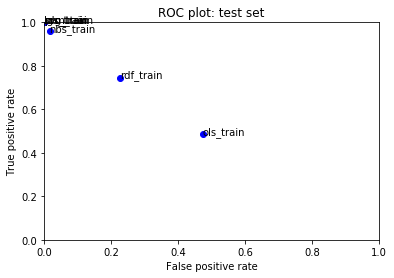

In [31]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [32]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [33]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
73
Like with any movie genre, there are good gangster movies and there are bad gangster movies. If you asked me to name a good gangster movie, I'd have dozens to choose from. If you asked me to name a bad gangster movie, probably the first one to pop up in my mind is one that still has me in a sort of depression of disappointment about a week since I saw the film for the first and I promise you, the last time. That film is \The General\", unrelated to the 1926 silent film of the same name. This is a very dry, very slow gangster epic that raises questions not about the story (it's more than easy to follow) but about why the filmmakers chose to make this rather flimsy endeavor.<br /><br />Like \"Goodfellas\" (1990) and \"American Gangster\" (2007)two superior mob movies\"The General\" is based on real people and true events. The film revolves around an Irish criminal named Martin Cahill (Brendan Gleeson) who started his long chain of crimes stealing food as

1857
The direction struck me as poor man's Ingemar Bergman. The inaudible dialogue was annoying. The somber stoicism that all characters except Banderas' showed made me think they were drugged. I think the director ruined it for me.
* * * * * * * * * 
2188
Good movies are original, some leave a message or touch you in a certain way, but sometimes you're not in the mood for that. <br /><br />I wanted something simple, no thinking just plain action when I watched this one. It started of good and was quite entertaining, so why a bad review. Well in the end the movie lost it's credibility. The storyline wasn't that cheesy at all, the action was not too special but overall good, acting was OK, so more than enough to satisfy my needs. But all got ruined because things happened that were over the top, and it left me with a bad feeling. They should have put a little more effort in making everything credible and would have gotten a 7 in the \no thinking just plain action\" category. So in concl

3668
Yeah. Pretty sure I saw this movie years ago when it was about the Supremes.<br /><br />Another recycled storyline glitzed up Hollywood-style, borrowing scripts from better making-it-in-the-music-industry films.<br /><br />Nothing original here.<br /><br />More make-up, glammier costumes and choreography = more money for the questionably \talented\" Beyonce draw.<br /><br />If you like the throwback style, you should appreciate actual groups who struggled (without having digitized voices and a Hollywood empire).<br /><br />Beyonce's involvement makes this hypocritical garbage."
* * * * * * * * * 
3736
\Smokey And The Bandit\" wasn't exactly Shakespeare, but then nobody wanted it to be. It was lowdown slapstick, but it did have brains. It had a very smart script with definable characters and a fun wrap-up. People came out of the theater smiling. \"Hooper\" provides none of this. There is no reason to smile. If it's supposed to be a tribute to the Hollywood Stuntman, it makes them l

6673
I've gotta say, I usually like horror movies that i've never seen... however, this one was just to pathetic for my gory taste. I'm used to the gory, gut wrenching types... but this particular movie was lame. The acting was horrible (yet the corny (no pun intended) one-liners were cute). And the sequel to it, Scarecrow Slayer was even worse! Yes, probably, when it first came out, there was a huge rave about it and people liked it. But when movies like The Ring and The Exorcist of Emily Rose come out, movies like these make movies like Scarecrow seem childish. If you want a movie to just pass the time, pick this one! The special effects are cheesy as heck. But seeing that it was a low budget movie, I can kind of see where that would come in. This will kind of remind you of the movie \Children Of The Corn.\" Independent movies rock.... most of the time. So if you want to see a scarecrow killing people with corncobs, or in the sequel, 2 scarecrows going at it, then these movies would 

9253
MAJOR LEAGUE: BACK TO THE MINORS (1998) ½* <br /><br />Starring: Scott Bakula, Eric Bruskotter, Corbin Bernsen, Dennis Haysbert, Jensen Daggett, Written and directed by John Warren 100 minutes Rated PG-13 (for language and some violence) <br /><br />By Blake French: <br /><br />     Believe it or not, in the new John Warren comedy \MAJOR LEAGUE: BACK TO THE MINORS\" there is one funny scene. It consists of a sequence where an infuriated coach throws a baseball hard into the wall behind him only to have it hit the cement and bounce back and smash him in the face. It's not much, but with the exception of a few one-liners, it's all this film has to offer...enough said. <br /><br />This movie is not only structurally impaired, characteristically undeveloped, predictable and badly written, but also just plain bad. Even non-critical audience members will hate this movie with all that they got. It is so familiar it just isn't funny. <br /><br />How many times does the same movie about sp

11655
I had eagerly awaited the first screening of this film ever since it was given to me on DVD at Christmas. Having reserved a special slot for it last night, I sat down to watch it with my daughter (aged 17 and a Film Studies student), with chocolates of course, in eager anticipation. We love Jane Austin.<br /><br />After just the first two minutes we knew we were sunk. The shaky camera shots and angles, general poor cinematography, direction and wooden performances had already left us feeling flat and dissatisfied. Despondent, we viewed on.<br /><br />Anne, played by Sally Hawkins, looked oddly and with no particular purpose, directly at the camera on several occasions, breaking our hard-won 'fantasy of the moment' and engaging us directly in an almost 'I'll find you' stalking fashion.<br /><br />Poor Rupert Penry-Jones, who played Captain Wentworth, did his best with the script and direction, bless him. I hope they paid him well, however, as he was practically drowned on one occa

14509
I don't normally feel much of an incentive to comment on films I don't like, but in a case like this one, I just have to say something. This movie is terrible, illogical, and stupid. There are so many flaws in the storytelling that I don't even feel obliged to elaborate on because it's time for me to move on from this experience. The most annoying point is, however, that at no point in the film does anyone explain whether the motivations for Bacon's character's madness are due to a power trip or a physiological reaction to his condition.<br /><br />Granted the special effects are impressive, and in the past Paul Verhoeven has done some good stuff (the director's cut of Robocop on DVD is great). However, this movie is stupid and generally doesn't come near to explaining the point or technical aspect of the subject matter, and instead settles for predictable action without any enjoyment.<br /><br /> In short, as many other reviews here say (wish I had read them before...) - Stay aw

17339
\New Best Friend\" is another entry in the \"steal another woman's life\" sub-genre; the best of which are \"Single White Female\" and \"The Hand That Rocks the Cradle\"; the worse of which you can catch almost any afternoon on the Lifetime Channel. For some reason this type of identity theft happens exclusively to women.<br /><br />There are just two basic ways to play this type of story. You can make the woman evil at the beginning and let the audience watch knowingly as she hatches and implements her evil scheme. Or you use misdirection to make her appear a good person, as a seemingly unplanned series of events break in her favor until she is revealed to be evil in the climatic scene. Unfortunately the makers of \"New Best Friend\" could not decide how they wanted to play it and things crash and burn early. We first meet Alicia (Mia Kirshner) scamming the college's financial aid office for scholarship money. We now know that she is a bad person and will view all her subsequent

19786
Bingo is the game, bullshit is the name. Rarely has the screen been smeared with such a blown-up hodgepodge of half-baked conspiracy theories, puritan prudery, and new-age gibberish. The bulk of the story is set at Viciente, a Cristian resort in the Peruvian jungle. Think Tolkien's Rivendell meets Star Trek's Planet Baku, inhabited by dimwitted followers of a not-so-mysterious, but surprisingly narrow-minded cult of love and peace. Thanks to gruesome acting and tacky production design (the rainbow-colored visualization of the mysterious all-healing \energy\" is particularly hideous), \"The Celestine Prophecies\" looks and feels like a discarded 1980s \"Twilight Zone\" episode. Factual errors regarding church history and nomenclature abound. I can't believe Hector Elizondo agreed to be a part of this. Maybe it was made without his consent, Bowfinger style. May the Lord have mercy on the director, the screenwriter, the author of the novel, and the poor souls who see the movie or re

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [34]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 1200, 'TN': 1326, 'FP': 1161, 'FN': 1313, 'Accuracy': 0.5052, 'Precision': 0.5082592121982211, 'Recall': 0.477516912057302, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [35]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2116, 'TN': 2054, 'FP': 433, 'FN': 397, 'Accuracy': 0.834, 'Precision': 0.8301294625343272, 'Recall': 0.8420214882610426, 'desc': 'svm_test'}


### MODEL: logistic regression

In [36]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2136, 'TN': 2043, 'FP': 444, 'FN': 377, 'Accuracy': 0.8358, 'Precision': 0.827906976744186, 'Recall': 0.8499801034619976, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [37]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 1838, 'TN': 1834, 'FP': 653, 'FN': 675, 'Accuracy': 0.7344, 'Precision': 0.7378562826174228, 'Recall': 0.7313967369677676, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [38]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2129, 'TN': 2036, 'FP': 451, 'FN': 384, 'Accuracy': 0.833, 'Precision': 0.8251937984496124, 'Recall': 0.8471945881416634, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [39]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2161, 'TN': 2072, 'FP': 415, 'FN': 352, 'Accuracy': 0.8466, 'Precision': 0.8388975155279503, 'Recall': 0.8599283724631914, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [40]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 1832, 'TN': 1908, 'FP': 579, 'FN': 681, 'Accuracy': 0.748, 'Precision': 0.7598506843633347, 'Recall': 0.7290091524074811, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

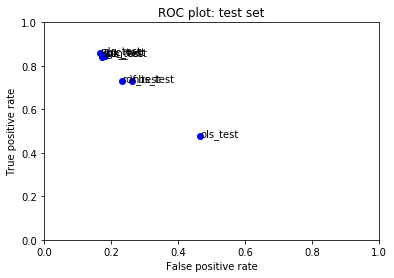

In [41]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [42]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=44, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  waste_count
0         131           5            0
1         169          15            1
2         176          18            0
3         112           5            0
4         133           8            0
5         331          20            0
6         121    

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [43]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdf.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48608


In [44]:
raw_data.head()

,id,review,word_count,punc_count,waste_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0
1,8348_2,This movie is a disaster within a disaster fil...,169,15,1
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,0
3,7186_2,Afraid of the Dark left me with the impression...,112,5,0
4,12128_7,A very accurate depiction of small time mob li...,133,8,0


In [45]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [46]:
my_submission.shape

(25000, 2)

In [47]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('./sample_submissions/moviereviews_sample_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation